In [1]:
import torch
from scipy.io import loadmat
import matplotlib.pyplot as plt
from pina.model import CAE
from pina import LabelTensor
import numpy as np

In [18]:
data = loadmat("Burgers_FOM.mat")
u = data['u_Mat'].T # (nt,nx)
nt = u.shape[0] 
nx = u.shape[1]
L = data['L'] # (nx,1)
L = L.reshape(nx)
t = data['time'] # (nt,1)
t = t.reshape(nt)

## getting domain boundaries to define the domain in the PINA problem
x_dom = [L[0], L[-1]]
t_dom = [t[0], t[-1]]

## making L and t LabelTensors as required by PINA
# L = LabelTensor(L,'x')
# t = LabelTensor(t,'t')
## train test split
# train size is 80% of data
train_size = int(0.8*nt)
test_size = nt-train_size
gen = torch.Generator()
# setting a seed for reproducibility
gen.manual_seed(1)
train,test = torch.utils.data.random_split(range(nt),[train_size,test_size],generator=gen)
u_train = torch.Tensor(u[train.indices,:])
u_test = torch.Tensor(u[test.indices,:])


## rehaping u to have 1 channel, as required by Conv1D
## also making u a LabelTensor as reuqired by PINA
u = u.reshape((nt,1,nx))
u_train = u_train.reshape((train_size,1,nx))
u_test = u_test.reshape((test_size,1,nx))
labels = [f'u{i}' for i in range(u.shape[-1])]
u = LabelTensor(u,labels)
u_train = LabelTensor(u_train,labels)
u_test = LabelTensor(u_test,labels)

cae = torch.load('pinn_cae_burger_loss.pt')

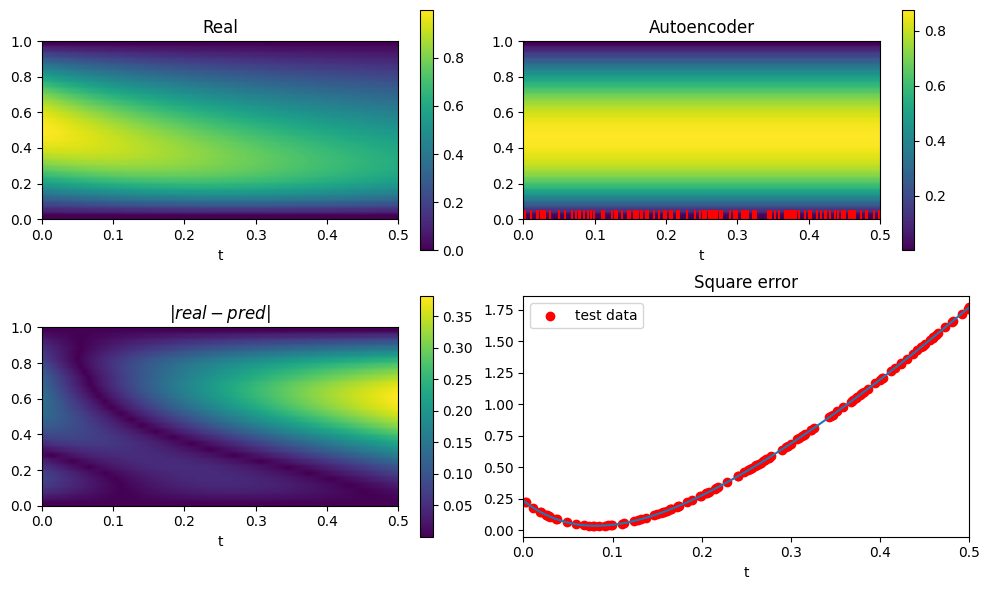

In [19]:
pred = cae(u).detach().numpy().reshape((nt,nx)).T
u_np = u.reshape((nt,nx)).numpy().T
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(221)
real_plt = ax1.imshow(u_np,extent=[t[0],t[-1],L[0],L[-1]])
ax1.set_aspect(0.25)
ax1.set_title('Real')
ax1.set_xlabel('t')
fig.colorbar(real_plt)

ax2 = fig.add_subplot(222)
rec_plt = ax2.imshow(pred,extent=[t[0],t[-1],L[0],L[-1]])
ax2.vlines(t[test.indices],0,0.05,'r')
ax2.set_aspect(0.25)
ax2.set_title('Autoencoder')
ax2.set_xlabel('t')
fig.colorbar(rec_plt)

diff = np.abs(u_np-pred)
err = np.sum(diff**2,axis=0)
mse = np.mean(err)

ax3 = fig.add_subplot(223)
err_plt = ax3.imshow(diff,extent=[t[0],t[-1],L[0],L[-1]])
ax3.set_aspect(0.25)
ax3.set_title(r'$|real - pred|$')
ax3.set_xlabel('t')
fig.colorbar(err_plt)

ax4 = fig.add_subplot(224,sharex = ax2)
ax4.plot(t[:],err)
ax4.scatter(t[test.indices],err[test.indices],c='r',label='test data')
ax4.legend()
ax4.set_title("Square error")
ax4.set_xlabel('t')
fig.tight_layout()

In [20]:
# fig.savefig('../../errors_phys_t0.png')